In [36]:
import torch
import torchvision
import torchvision.transforms as transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# GPU Check

print(device)

cuda:0


In [37]:
batch_size = 4


def min_max_normalization(tensor, new_min=0, new_max=255):
    v_min = tensor.min()
    v_max = tensor.max()
    normalized_tensor = (tensor - v_min) / (v_max - v_min) * (
        new_max - new_min
    ) + new_min
    return normalized_tensor


def unnormalization_min_max(
    normalized_tensor, tensor_min, tensor_max, new_min=0, new_max=255
):
    tensor_range = tensor_max - tensor_min
    normalized_range = new_max - new_min
    tensor = (
        (normalized_tensor - new_min) / normalized_range
    ) * tensor_range + tensor_min
    return tensor


transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        #  transforms.Lambda(lambda x: min_max_normalization(x))
    ]
)

testset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)

test_tensor_min = testset.data.min()
test_tensor_max = testset.data.max()

testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=True, num_workers=0
)

trainset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=0
)

train_tensor_min = trainset.data.min()
train_tensor_max = trainset.data.max()

classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)

Files already downloaded and verified
Files already downloaded and verified
Finished Training


In [48]:
def train(num_epochs, optimizer, model, criterion):
    for epoch in range(num_epochs):
        running_loss = 0.0
        for index, data in enumerate(trainloader, 0):
            inputs, labels = data

            optimizer.zero_grad()

            # print(inputs.shape)

            # Reshape the inputs tensor
            # inputs = inputs.view(inputs.shape[0], -1)

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if index % 2000 == 1999:
                print(f"[{epoch + 1}, {index + 1:5d}] loss: {running_loss/2000:.3f}")
                running_loss = 0.0

    print("Finished Training")


def accuracy_check(model, data_set):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in data_set:
            images, labels = data
            # calculate outputs by running images through the network
            # images = images.view(inputs.shape[0], -1)
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(
        f"Accuracy of the network on the 10000 test images: {100 * correct // total} %"
    )

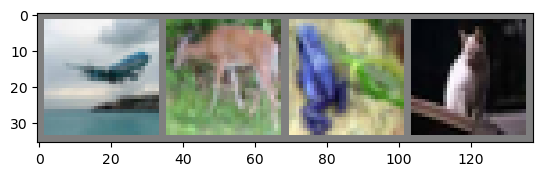

plane deer  frog  cat  


In [39]:
import matplotlib.pyplot as plt
import numpy as np


def img_show(img):
    img = img / 2 + 0.5
    # img = unnormalization_min_max(img, train_tensor_min, train_tensor_max)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# random images
dataiter = iter(trainloader)
images, labels = next(dataiter)

img_show(torchvision.utils.make_grid(images))
# print labels
print(" ".join(f"{classes[labels[j]]:5s}" for j in range(batch_size)))

In [41]:
import torch.nn as nn
import torch.nn.functional as F

# Build a multi-layer perceptron with the following layers:
#  Dense layer with 512 units and a sigmoid activation function
#  Dense layer with 512 units and a sigmoid activation function
#  Dense layer (output layer) with 10 units (representing 10 classes in the dataset) and a suitable activation function for the classification task


class SimpleMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        # x = self.fc3(x)
        x = F.softmax(self.fc3(x), dim=1)
        return x


mlp = SimpleMLP()

In [42]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.001)

In [43]:
num_epochs = 5
train(num_epochs, optimizer, mlp, criterion)

[1,  2000] loss: 2.185
[1,  4000] loss: 2.140
[1,  6000] loss: 2.128
[1,  8000] loss: 2.114
[1, 10000] loss: 2.113
[1, 12000] loss: 2.103
[2,  2000] loss: 2.085
[2,  4000] loss: 2.089
[2,  6000] loss: 2.077
[2,  8000] loss: 2.082
[2, 10000] loss: 2.086
[2, 12000] loss: 2.082
[3,  2000] loss: 2.062
[3,  4000] loss: 2.064
[3,  6000] loss: 2.070
[3,  8000] loss: 2.075
[3, 10000] loss: 2.067
[3, 12000] loss: 2.063
[4,  2000] loss: 2.058
[4,  4000] loss: 2.048
[4,  6000] loss: 2.059
[4,  8000] loss: 2.054
[4, 10000] loss: 2.051
[4, 12000] loss: 2.059
[5,  2000] loss: 2.049
[5,  4000] loss: 2.052
[5,  6000] loss: 2.051
[5,  8000] loss: 2.052
[5, 10000] loss: 2.049
[5, 12000] loss: 2.048
Finished Training


In [ ]:
PATH = './simple_mlp_cifar_net.pth'
torch.save(mlp.state_dict(), PATH)

In [49]:
accuracy_check(mlp, trainloader)

Accuracy of the network on the 10000 test images: 41 %


In [50]:
# Build a Convolutional neural network with the following architecture:
#  2D Convolutional layer with 64 filters (size of 3x3) and ReLU activation function
#  2D Convolutional layer with 64 filters (size of 3x3) and ReLU activation function
#  Flatten layer (to pass to the Fully Connected layers)
#  Fully connected (Dense) layer with 512 units and a sigmoid activation function
#  Fully connected layer with 512 units and a sigmoid activation function
#  Dense layer (output layer) with 10 units and a suitable activation function for the classification task

class CNN1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv2D1 = nn.Conv2d(3, 64, 3)
        self.conv2D2 = nn.Conv2d(64, 64, 3)
        self.fc1 = nn.Linear(50176, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        x = F.relu(self.conv2D1(x))
        x = F.relu(self.conv2D2(x))
        x = torch.flatten(x, 1)
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x
    
cnn1 = CNN1()

optimizer = optim.Adam(cnn1.parameters(), lr=0.001)

In [51]:
train(num_epochs, optimizer, cnn1, criterion)

[1,  2000] loss: 2.293
[1,  4000] loss: 2.263
[1,  6000] loss: 2.235
[1,  8000] loss: 2.231
[1, 10000] loss: 2.238
[1, 12000] loss: 2.245
[2,  2000] loss: 2.230
[2,  4000] loss: 2.237
[2,  6000] loss: 2.284
[2,  8000] loss: 2.264
[2, 10000] loss: 2.257
[2, 12000] loss: 2.249
[3,  2000] loss: 2.241
[3,  4000] loss: 2.248
[3,  6000] loss: 2.244
[3,  8000] loss: 2.261
[3, 10000] loss: 2.244
[3, 12000] loss: 2.268
[4,  2000] loss: 2.265
[4,  4000] loss: 2.259
[4,  6000] loss: 2.259
[4,  8000] loss: 2.269
[4, 10000] loss: 2.277
[4, 12000] loss: 2.284
[5,  2000] loss: 2.298
[5,  4000] loss: 2.302
[5,  6000] loss: 2.301
[5,  8000] loss: 2.296
[5, 10000] loss: 2.296
[5, 12000] loss: 2.285
Finished Training


In [52]:
accuracy_check(cnn1, trainloader)

Accuracy of the network on the 10000 test images: 14 %


In [53]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [54]:
train(num_epochs, optimizer, net, criterion)

[1,  2000] loss: 2.139
[1,  4000] loss: 1.807
[1,  6000] loss: 1.655
[1,  8000] loss: 1.562
[1, 10000] loss: 1.518
[1, 12000] loss: 1.461
[2,  2000] loss: 1.395
[2,  4000] loss: 1.383
[2,  6000] loss: 1.347
[2,  8000] loss: 1.308
[2, 10000] loss: 1.297
[2, 12000] loss: 1.290
[3,  2000] loss: 1.218
[3,  4000] loss: 1.206
[3,  6000] loss: 1.209
[3,  8000] loss: 1.186
[3, 10000] loss: 1.189
[3, 12000] loss: 1.177
[4,  2000] loss: 1.123
[4,  4000] loss: 1.130
[4,  6000] loss: 1.100
[4,  8000] loss: 1.105
[4, 10000] loss: 1.107
[4, 12000] loss: 1.102
[5,  2000] loss: 1.040
[5,  4000] loss: 1.046
[5,  6000] loss: 1.044
[5,  8000] loss: 1.034
[5, 10000] loss: 1.055
[5, 12000] loss: 1.046
Finished Training


In [55]:
accuracy_check(net, trainloader)

Accuracy of the network on the 10000 test images: 65 %


In [59]:
# Build a Convolutional Neural network with the following architecture:
#  2D Convolutional layer with 64 filters (size of 3x3) and ReLU activation function
#  2x2 Maxpooling layer
#  2D Convolutional layer with 64 filters (size of 3x3) and ReLU activation function
#  2x2 Maxpooling layer
#  Flatten layer (to pass to the Fully Connected layers)
#  Fully connected (Dense) layer with 512 units and a sigmoid activation function
#  Dropout layer with 0.2 dropout rate
#  Fully connected layer with 512 units and a sigmoid activation function
#  Dropout layer with 0.2 dropout rate
#  Dense layer (output layer) with 10 units and a suitable activation function for the classification task


class CNN2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv2D1 = nn.Conv2d(3, 64, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2D2 = nn.Conv2d(64, 64, 3)
        self.dropout = nn.Dropout2d(0.2)
        self.fc1 = nn.Linear(2304, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        x = F.relu(self.conv2D1(x))
        x = self.pool(x)
        x = F.relu(self.conv2D2(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = torch.sigmoid(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


cnn2 = CNN2()

optimizer = optim.SGD(cnn2.parameters(), lr=0.001, momentum=0.9)

In [60]:
train(num_epochs, optimizer, cnn2, criterion)

[1,  2000] loss: 2.377
[1,  4000] loss: 2.347
[1,  6000] loss: 2.275
[1,  8000] loss: 2.089
[1, 10000] loss: 1.978
[1, 12000] loss: 1.899
[2,  2000] loss: 1.802
[2,  4000] loss: 1.715
[2,  6000] loss: 1.654
[2,  8000] loss: 1.583
[2, 10000] loss: 1.576
[2, 12000] loss: 1.534
[3,  2000] loss: 1.475
[3,  4000] loss: 1.449
[3,  6000] loss: 1.428
[3,  8000] loss: 1.412
[3, 10000] loss: 1.354
[3, 12000] loss: 1.358
[4,  2000] loss: 1.313
[4,  4000] loss: 1.298
[4,  6000] loss: 1.260
[4,  8000] loss: 1.258
[4, 10000] loss: 1.230
[4, 12000] loss: 1.211
[5,  2000] loss: 1.161
[5,  4000] loss: 1.158
[5,  6000] loss: 1.142
[5,  8000] loss: 1.105
[5, 10000] loss: 1.107
[5, 12000] loss: 1.086
Finished Training


In [61]:
accuracy_check(cnn2, trainloader)

Accuracy of the network on the 10000 test images: 63 %
